## Example Notebook to use PyTFit5 with BLS CPU version and TransitFit5 transit modelling.

In [1]:
import numpy as np
import pytfit5.bls_cpu as gbls
import pytfit5.transitPy5 as tpy5
import os

import matplotlib.pyplot as plt  #MatPlotLib for some simple plots 

import importlib.util #To check if certain libraries are available 

In [4]:
gbls_inputs = gbls.gbls_inputs_class() # Initialize needed inputs

tic = 29991541
gbls_inputs.lcdir    = "./"
gbls_inputs.filename = "tlc"+str(tic)+"_5.d.dat"
# gbls_inputs.filename = "tlc"+str(tic)+".dat"

# Read in photometry to photclass
phot = tpy5.readphot(gbls_inputs.lcdir + gbls_inputs.filename)

# Data should be normalized around 1 for BLS.  The example is centred around 0.  So we fix that here.
phot.flux += 1.0  # Ensure flux is around 0
phot.flux_f = phot.flux   # Make a copy of original flux

# Remove any offset from time stamps
gbls_inputs.zerotime = 1325.0

# 0 == no plots ; 1 = make a plot ; 2 make a plot and save it ; 3 just save the plot
gbls_inputs.plots = 1  #default is 1 

# Set frequency range by setting freqs1 and freqs2
# gbls_inputs.freq1 = 1/100 # scan from 100 days to 2 days
# gbls_inputs.freq2 = 1/2

# Set stellar parameters for optimum duration search
# gbls_inputs.Mstar = 1.0  #default is M = 1, R = 1
# gbls_inputs.Rstar = 1.0

# Set multipro = 0 for single thread jobs.  Default is 1.  
# gbls_inputs.multipro = 1

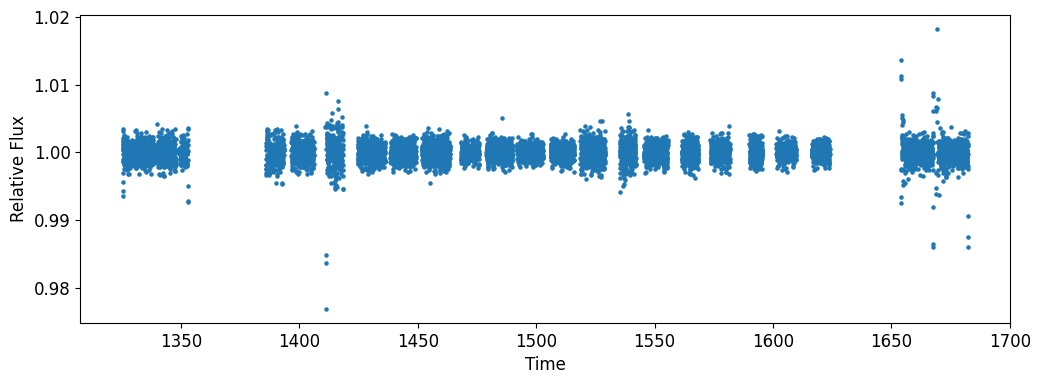

In [5]:
# Raw Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time,phot.flux, s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

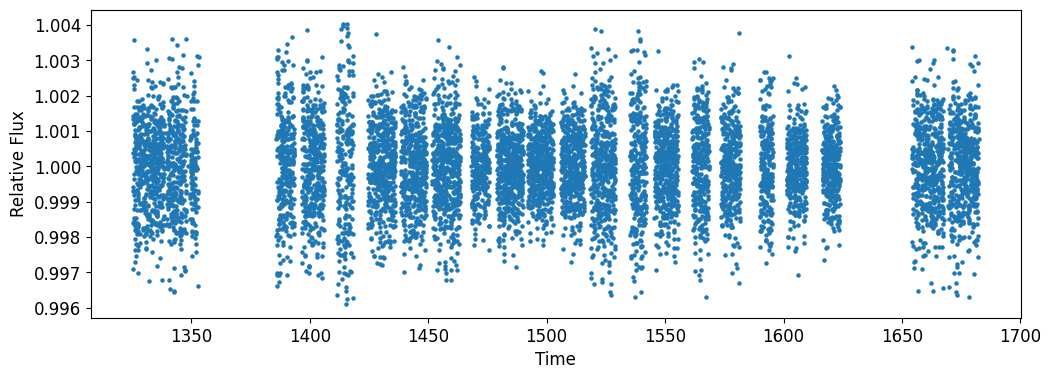

In [6]:
# Get default parameters
tpy5_inputs = tpy5.tpy5_inputs_class()

# Run the detrending and outlier detection (if needed) 
tpy5_inputs.boxbin = 5.0 # set detrending length
tpy5_inputs.nfitp  = 3   # Set polynomial order
tpy5.run_polyfilter(phot, tpy5_inputs)  # flux_f will contain the filtered photometry
tpy5.run_cutoutliers(phot, tpy5_inputs) # data clipping, phot.icut will flag bad data

# Do a simple 3-sigma cut 
med = np.median(phot.flux_f[(phot.icut==0)])
std = np.std(phot.flux_f[(phot.icut==0)])
phot.icut[np.abs(phot.flux_f - med) > 3.0 * std] = 1 # Add bad data flags to icut array

# Processed Light curve 
fig=plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size': 12})
plt.scatter(phot.time[(phot.icut==0)],phot.flux_f[(phot.icut==0)], s=5)
# plt.scatter(phot.time[phot.icut==0],phot.flux_f[phot.icut==0], s=5)
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.show()

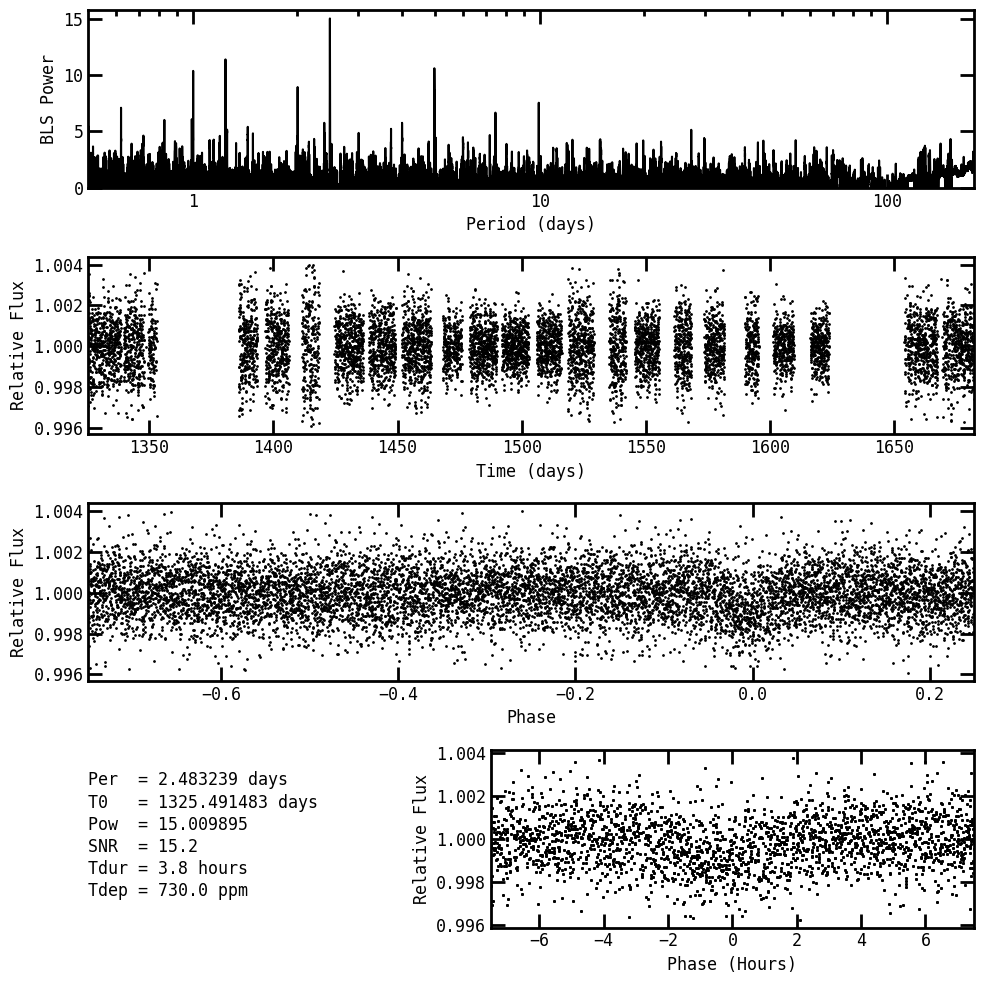

In [7]:
# Set up the BLS inputs and run
gbls_inputs          = gbls.gbls_inputs_class() # Initialize needed inputs
gbls_inputs.zerotime = 0.0
gbls_inputs.Rstar    = 1.0
gbls_inputs.Mstar    = 1.0
gbls_inputs.plots    = 1 # 1=X11, 2=both, 0=none
# Set frequency range
gbls_inputs.freq1    = 2/(np.max(phot.time) - np.min(phot.time)) # From 1/2 the time baseline -- i.e., 2 transits minimum
gbls_inputs.freq2    = -1 # default is 1/2 days
gbls_inputs.filename = "BLS_Test"  # Used for naming the file, extension replaced with PNG.

# Run BLS, applying data cuts
gbls_ans = gbls.bls(gbls_inputs, phot.time[(phot.icut==0)], \
                                 phot.flux_f[(phot.icut==0)])

## Python Transit modelling section

- needs preconditioning of data prior to modelling. (protect transits during detrending and clipping)
- move zerotime to routine to leave original phot.time intack
- use flux_f instead of flux for modelling -- leaves original photometry intack
- use icut and other flags to mark bad data 

In [9]:
import pytfit5.transitmodel as transitm
import pytfit5.keplerian as kep
import pytfit5.transitfit as transitf
import pytfit5.transitplot as transitp

# Check for optional exotic limb darkening package.
if importlib.util.find_spec("exotic_ld"):
    from exotic_ld import StellarLimbDarkening
    use_exotic_ld = 1
else:
    use_exotic_ld = 0

In [10]:
# Create an initial guess for all 18 parameters
sol     = transitm.transit_model_class() # Single planet model has up-to 18-model parameters

# Parameters that define the star/scene for the transit model
sol.rho = kep.rhostar(gbls_ans.bper, gbls_ans.tdur)    # Guess for mean stellar density based on transit-duration and period (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening 
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = 0.0    # Photometric zero point

# Set up Limb-darkening (q1, q2 parameterization)
if use_exotic_ld == 1:
    ld_data_path = './exotic_ld_data/'  #location of exotic spectral library 
    ld_model = 'mps1'
    sld = StellarLimbDarkening(tpy5_inputs.feh, tpy5_inputs.teff, tpy5_inputs.logg, ld_model, ld_data_path)
    ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
    sol.nl3 = ld[0]
    sol.nl4 = ld[1]
else:
    sol.nl3 = 0.311 #Solar values for TESS
    sol.nl4 = 0.270 

#The parameters below are stored as arrays, as the model is multi-planet ready.
sol.t0  = [gbls_ans.epo + gbls_ans.bper]             # Center of transit time (days)
sol.per = [gbls_ans.bper*2]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(gbls_ans.depth)]  # Rp/R*
sol.ecw = [0.0]                      # sqrt(e)cos(w)
sol.esw = [0.0]                      # sqrt(e)sin(w)
sol.krv = [0.0]                      # RV amplitude (m/s)
sol.ted = [0.0]                      # thermal eclipse depth (ppm)
sol.ell = [0.0]                      # Ellipsodial variations (ppm)
sol.alb = [0.0]                      # Albedo amplitude (ppm)
sol.npl = 1                          # Number of planets

In [11]:
# Mark in-transit data.  Since BLS will likely underestimate the transit-duration, we will pad to be safe.
kep.mark_intransit_data(phot, sol, tdurcut = 1.0)  # tdurcut is the amount of +/- time to protect centred on the transit 
tpy5.run_polyfilter(phot, tpy5_inputs)         # Re-apply detrending to protect the transit event from distortion

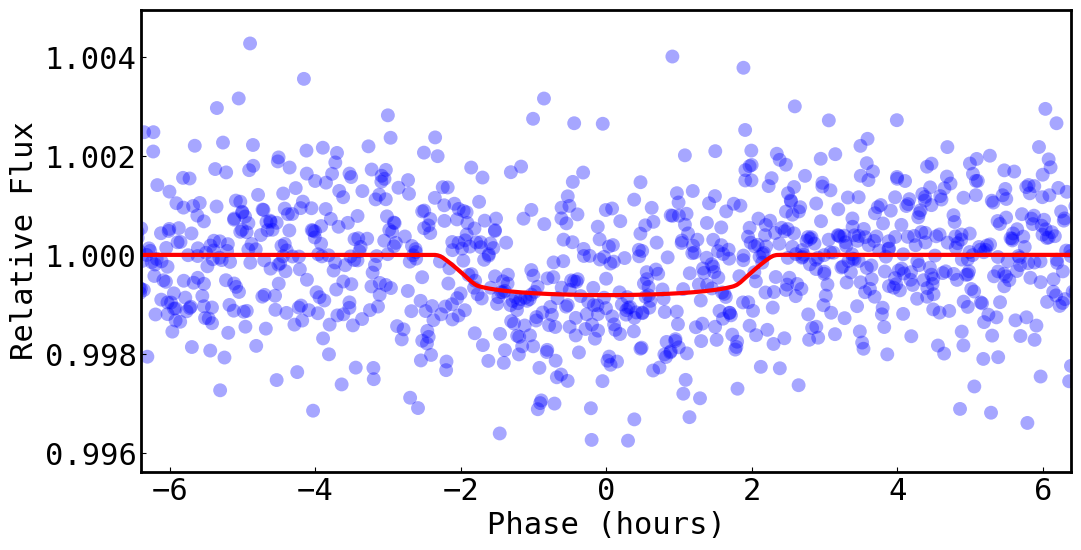

In [12]:
# Plot the initial model and data
pl_plot = 1 # Which planet to plot
transitp.plotTransit(phot, sol, pl_to_plot=pl_plot)

In [13]:
# Define the parameters to fit
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

# Fit the data
sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot)

In [14]:
# See the fitted parameter (Note the error is a simple co-variance matrix at this stage)
transitp.printParams(sol_fit)

ρ* (g/cm³):                     0.6463547 ± 17.3728205
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         7.245e-05 ± 7.199e-05
t0 (days):                      1.328e+03 ± 9.920e-03
Period (days):                  4.9661600 ± 0.0002462
Impact parameter:               0.5479418 ± 11.6533283
Rp/R*:                          0.0274593 ± 0.0445621
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


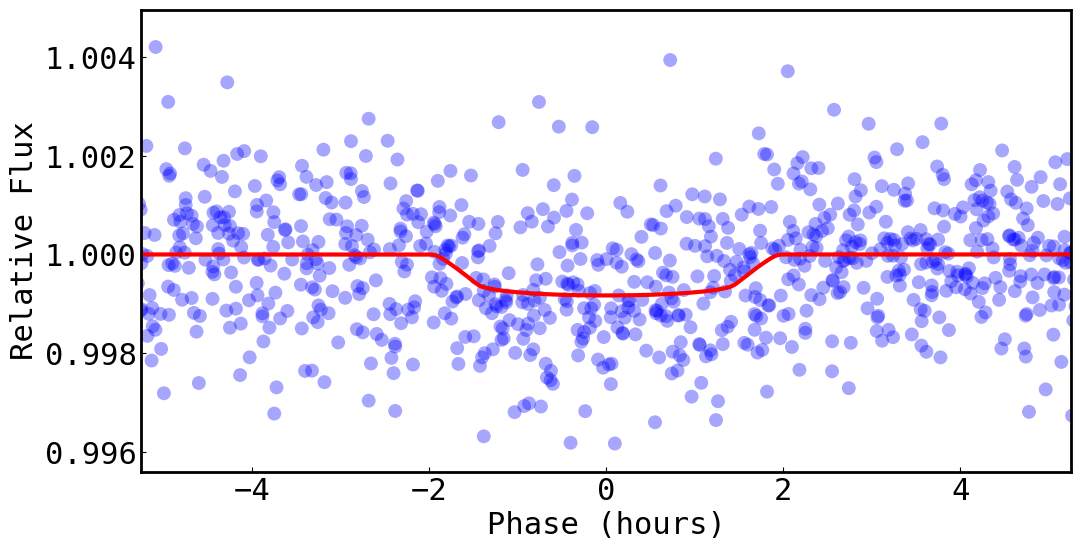

In [15]:
# Plot the optimized model and data
pl_plot = 1
transitp.plotTransit(phot, sol_fit, pl_to_plot=pl_plot)

## MCMC

- add tqdm to MCMC chain generation to give user an indication of progress
- add flag to remove verbose output
- add figure generation that plots a selection of models from MCMC to show scatter. 

In [16]:
import pytfit5.transitmcmc as tmcmc

In [17]:
nsteps1 = 10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 50000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 50000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer

In [18]:
if np.rint(np.median(phot.flux)) != 1:
    raise ValueError

# Generate input for mcmc
lnprob, x, beta = tmcmc.genmcmcInput(sol_fit, params_to_fit)
sol_a = sol_fit.to_array()
serr = sol_fit.err_to_array()

# Cut out of transit
phot_cut = tmcmc.cutOutOfTransit(sol_fit, phot)

params = [nsteps1, nsteps2, nsteps_inc, burninf, niter_cor, burnin_cor, nthin, nloopmax, converge_crit, buf_converge_crit]

In [19]:
chain, accept, burnin = tmcmc.demcmcRoutine(x, beta, phot_cut, sol_a, serr, params, lnprob)

runtest: [0.00977217 0.03573822 0.00076381 0.0003573 ]
Current Acceptance:  [0.01597444 0.63285714 0.55068079 0.53651267 0.01721664 0.05214724]
Current Acceptance:  [0.0484115  0.37640449 0.32668712 0.35429448 0.07496464 0.13483146]
Current Acceptance:  [0.1796875  0.17042254 0.22566372 0.18506998 0.16172107 0.23413897]
Current Acceptance:  [0.34844193 0.14573643 0.22566372 0.17912553 0.33634992 0.23413897]
Current Acceptance:  [0.41486068 0.16793893 0.22566372 0.17706821 0.33807267 0.23413897]
Current Acceptance:  [0.33477633 0.22205663 0.22566372 0.21085271 0.36070853 0.23413897]
Current Acceptance:  [0.28257457 0.22205663 0.22566372 0.28445748 0.34097859 0.23413897]
Current Acceptance:  [0.19905213 0.22205663 0.22566372 0.2735426  0.18741059 0.23413897]
Current Acceptance:  [0.20276498 0.22205663 0.22566372 0.2735426  0.16422287 0.23413897]
Current Acceptance:  [0.19631902 0.22205663 0.22566372 0.2735426  0.07957958 0.23413897]
Current Acceptance:  [0.2437223  0.22205663 0.22566372 

In [20]:
# Get statistics about the posterior from the Markov-Chain and print the results
sol_mcmc = tmcmc.getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

# you can get any individual value from the sol_mcmc class, for example the mean stellar density : rho and drho 

ρ* (g/cm³):                     0.5786655 ± 0.6759744
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                                 0.311 ± 0.0
q2:                                  0.27 ± 0.0
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         5.720e-05 ± 7.879e-05
t0 (days):                      1.328e+03 ± 1.977e-02
Period (days):                  4.9662725 ± 0.0004490
Impact parameter:               0.5126525 ± 0.2892776
Rp/R*:                          0.0268643 ± 0.0034831
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


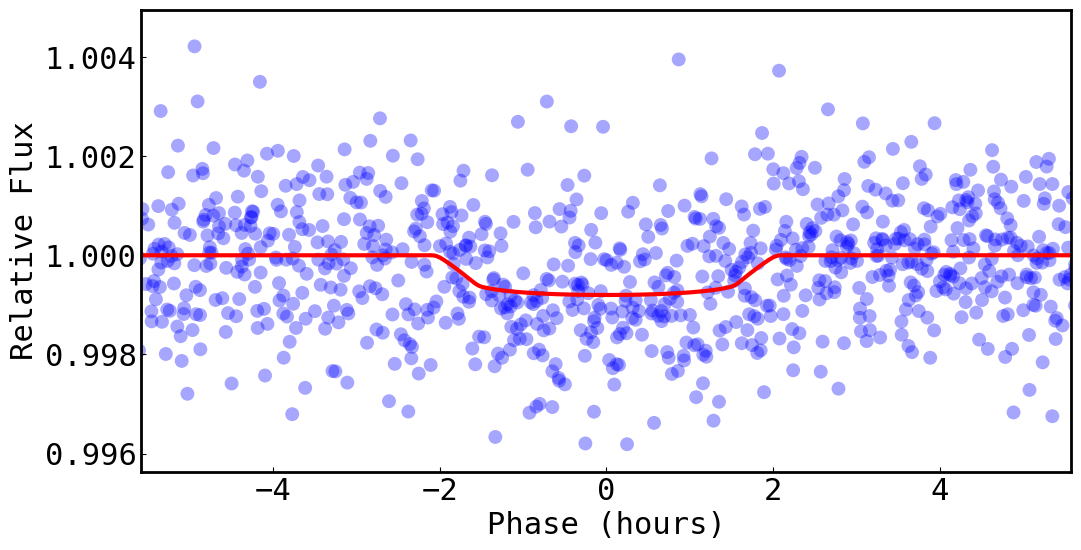

In [21]:
pl_plot = 1
transitp.plotTransit(phot, sol_mcmc, pl_to_plot=pl_plot)

In [22]:
import pytfit5.mcmcroutines as mcmc

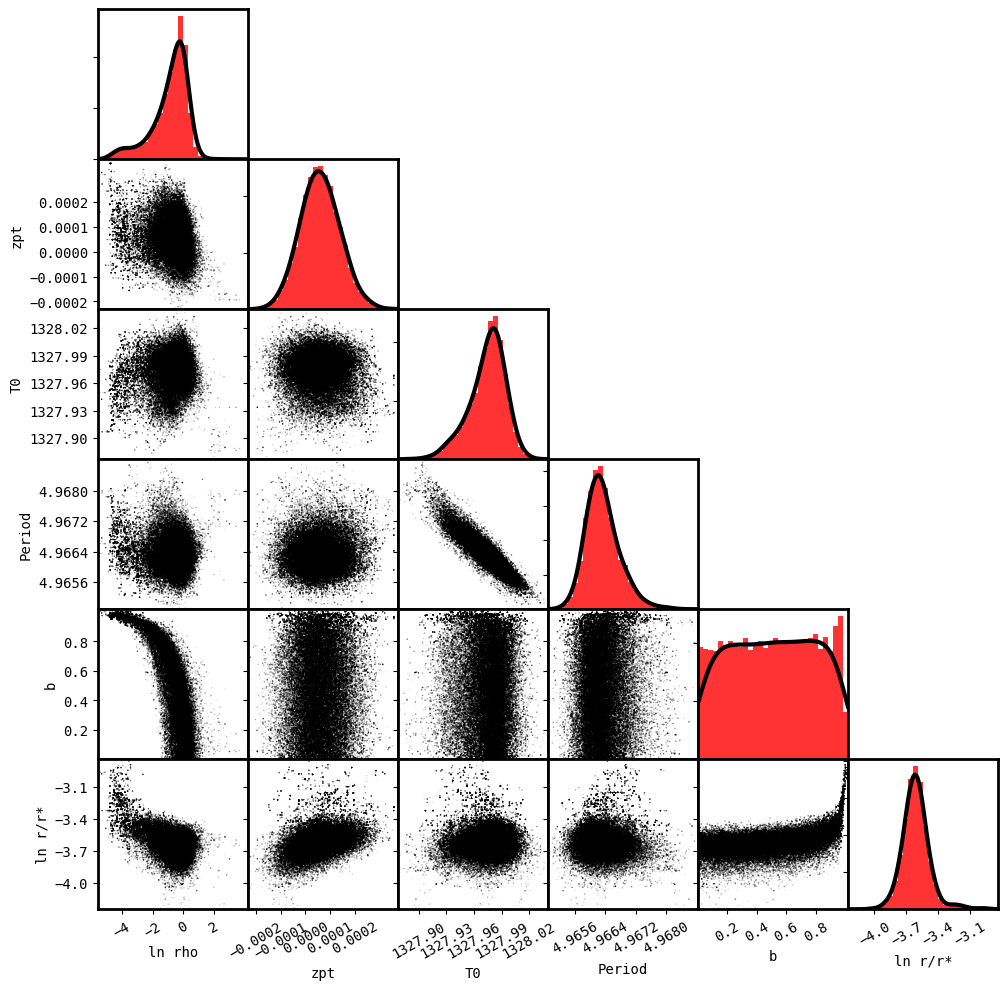

In [23]:
label = ["ln rho", "zpt", "T0", "Period", "b", "ln r/r*"]
color = ["red"]*14

plt.rcParams['font.size'] = 10
mcmc.triplot(chain, burnin, label, color, 30)